In [1]:
# tequila git commit hash
# afd00a8283f419add5520d64cf337b0ff0467792
# Note that a lot of symbols are re-used in the presentation for readability.
# It is advised to copy code into a save environment.

### Orbitals, Fermions and Gradients: Getting started with Tequila

`pip install git+https://github.com/aspuru-guzik-group/tequila.git`  

<img src="pics/tq_principle.png"  width="600px">  

Slides in notebook form:
[github.com/kottmanj/talks_and_material](https://github.com/kottmanj/talks_and_material)  


In [2]:
import tequila as tq
import numpy

## Warmup:

Original idea for quantum computers: Simulate nature  


<img src="pics/qpe_analogy_wbg.png" width="400px">  


Assume: $U = e^{i\frac{\theta}{2}G}$ with hermitian matrix $G$ and $\theta=2\pi$.  
For simplicity: Assume eigenvalues of $G$ are $0$ and $1$

Concrete example: $$ G = \sigma_x + 1 $$

In [3]:
G = 0.5*(tq.paulis.X(1)+1.0)

In [4]:
val, vec = numpy.linalg.eigh(G.to_matrix())
eigenstates = []
for i in range(2):
    wfn = tq.QubitWaveFunction.from_array(vec[:,i])
    print("energy = {:+2.5f}, wfn=".format(val[i]), wfn)
    eigenstates.append(wfn)

energy = +0.00000, wfn= -0.7071|0> +0.7071|1> 
energy = +1.00000, wfn= +0.7071|0> +0.7071|1> 


<img src="pics/qpe_analogy_circuit_wbg.png" alt="Simulated Laboratory" width="400px">  

In [5]:
a=2*numpy.pi
cU = tq.gates.Trotterized(generator=G, angle=a, control=0)
U = tq.gates.H(0) + cU + tq.gates.H(0)
wfn = tq.simulate(U)
print("wavefunction after circuit:\n", wfn)


wavefunction after circuit:
 +0.5000e^(-0.2500πi)|00> +0.5000e^(-0.2500πi)|10> +0.5000e^(+0.7500πi)|01> +0.5000e^(-0.2500πi)|11> 


In [53]:
Qp = tq.paulis.Qp(0) # Qp = |0><0| = 0.5(Z+1)
wfn2 = Qp(wfn)
wfn2 = wfn2.normalize()
print("wavefunction after measurements:\n",wfn2)
fidelity = numpy.abs(wfn2.inner(eigenstates[0]))**2
print("fidelity with eigenstate 0:", fidelity )

wavefunction after measurements:
 +0.7071e^(-0.2500πi)|00> +0.7071e^(+0.7500πi)|01> 
fidelity with eigenstate 0: 0.9999999999999998


### A Toy VQE

Example before: Quantum Phase Estimation (measure eigenvalues of Hermitian operator)  

Now: Variational Quantum Eigensolver (minimize expectation value of Hermitian operator)

$$ \min_{\theta} \langle H \rangle_{U(\theta)} $$


In [7]:
H = 0.5*(tq.paulis.X(0) + 1.0)
U = tq.gates.Ry(target=0, angle="a")
E = tq.ExpectationValue(H=H, U=U)

In [8]:
result = tq.minimize(E)

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 2 expectationvalues

active variables : 1

E=+0.50000000  angles= {a: 0.0}  samples= None
E=+0.26028723  angles= {a: -0.5}  samples= None
E=+0.00026787  angles= {a: -1.6035311193256832}  samples= None
E=+0.00001204  angles= {a: -1.5638552774723973}  samples= None
E=+0.00000000  angles= {a: -1.5707973321904534}  samples= None
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5


### Simulate and Compile Objectives

In [9]:
# simulate objectives
energy1 = tq.simulate(E, variables={"a": -numpy.pi/2})
# compile objectives and use as functions
f = tq.compile(E)
energy2 = f({"a":-numpy.pi/2})
# use different backends and options
energy3 = tq.simulate(E, variables={"a": -numpy.pi/2}, backend="cirq", samples=1000)


### Beyond Groundstates

Overlap punishment:  

$$ S^2\left(\phi, \psi\right)= \lvert\langle \phi \vert \psi \rangle\rvert^2 =  \langle Q_+ \rangle_{U_\phi^\dagger U_{\psi}} , \quad Q_+ = \lvert 00\dots0 \rangle\langle 00\dots0 \lvert$$ 

In [10]:
Uex = tq.gates.Ry(angle="b", target=0)
S2 = tq.ExpectationValue(H=tq.paulis.Qp(0), U=Uex+U.dagger())
opt_gs = {"a":-0.5*numpy.pi}
L = tq.ExpectationValue(H=H, U=Uex) + 10.0*S2

In [11]:
result_ex = tq.minimize(L, 
                        initial_values=opt_gs, 
                        variables=["b"])

 /home/jsk/projects/OpenVQE/src/tequila/optimizers/optimizer_base.py:422: TequilaWarning:initial_variables given but not complete: Autocompleted with zeroes


Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 2 expectationvalues
gradient        : 6 expectationvalues

active variables : 1

E=+5.49999475  angles= {b: 0.0, a: -1.5707973321904534}  samples= None
E=+1.68925405  angles= {b: 1.01, a: -1.5707973321904534}  samples= None
E=+1.75247025  angles= {b: 2.157473194149607, a: -1.5707973321904534}  samples= None
E=+1.00000119  angles= {b: 1.5700696738344724, a: -1.5707973321904534}  samples= None
E=+1.00000000  angles= {b: 1.5708347830881644, a: -1.5707973321904534}  samples= None
Optimization terminated successfully.
         Current function value: 1.000000
         Iterations: 3
         Function evaluations: 5
         Gradient evaluations: 5


<img src="pics/all_in_one_blackboard.png" width="400px">


In [12]:
a = tq.Variable("a")
angle = (-a**2).apply(tq.numpy.exp)
U = tq.gates.Ry(angle=angle*numpy.pi, target=0)
U += tq.gates.X(target=1, control=0)
H = tq.QubitHamiltonian("-1.0X(0)X(1)+0.5Z(0)+Y(1)")
E = tq.ExpectationValue(H=H, U=U)
dE = tq.grad(E, "a")
objective = E + (-(dE**2)).apply(tq.numpy.exp)
f = tq.compile(objective)

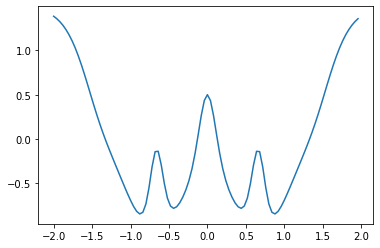

In [13]:
import matplotlib.pyplot as plt
start=-2.0
stop=2.0
values = {}
for value in [start + i/100*(stop-start) for i in range(100)]:
    values[value] = f({"a":value})
plt.plot(list(values.keys()), list(values.values()))
plt.show()

<img src="pics/nested_example.png" width="800px">

In [14]:
H =  tq.paulis.Sp(0)*tq.paulis.Sm(1)
H += tq.paulis.Sm(0)*tq.paulis.Sp(1)
U =  tq.gates.X(0)
U += tq.gates.QubitExcitation(angle=f, target=[0,1])
L2 = tq.ExpectationValue(H=H, U=U)**2
f2 = tq.compile(L2)

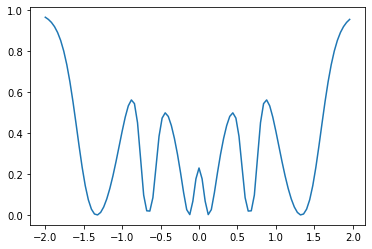

In [15]:
import matplotlib.pyplot as plt
start=-2.0
stop=2.0
steps=100
values = {}
for value in [start + i/steps*(stop-start) for i in range(steps)]:
    values[value] = f2({"a":value})
plt.plot(list(values.keys()), list(values.values()))
plt.show()

### Example: Meta-VQE  

A. Cervera-Lierta, JSK, A. Aspuru-Guzik, [ArXiv:2009.13545](https://arxiv.org/abs/2009.13545)  

Learn the relation of a parameters in the Hamiltonian and in the circuit  

<img src="pics/meta_vqe_cartoon.png" width="400px">

<img src="pics/meta_vqe_cartoon.png" width="300px">

In [16]:
def meta_angle(x):
    a = tq.assign_variable("a")
    b = tq.assign_variable("b")
    return x*a-b

def make_H(x):
    return tq.paulis.X(0) + x*tq.paulis.Z(0)

def make_U(angle):
    angle = tq.assign_variable(angle)
    return tq.gates.Ry(target=0, angle=angle*numpy.pi)

### Training

In [17]:
training_points = [0.0, 0.5, 1.0]
meta_objective = 0.0
for x in training_points:
    meta_objective += tq.ExpectationValue(H=make_H(x), U=make_U(meta_angle(x)))

meta_objective = 1.0/len(training_points)*meta_objective

In [18]:
meta_vqe_result = tq.minimize(meta_objective)

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 3 expectationvalues
gradient        : 18 expectationvalues

active variables : 2

E=+0.50000000  angles= {a: 0.0, b: 0.0}  samples= None
E=+0.03163936  angles= {a: -0.45168573145495755, b: 0.9033714629099151}  samples= None
E=-1.10308790  angles= {a: -0.20895075848145425, b: 0.4179015169629085}  samples= None
E=-0.60310841  angles= {a: -0.5721265537434792, b: 0.6376424028446308}  samples= None
E=-1.17348516  angles= {a: -0.29224800825863895, b: 0.468300832380787}  samples= None
E=-1.17658091  angles= {a: -0.23413025767017326, b: 0.518145642557484}  samples= None
E=-1.17678094  angles= {a: -0.24759858034771412, b: 0.5085406576584631}  samples= None
Optimization terminated successfully.
         Current function value: -1.176781
         Iterations: 4
         

### Testing

In [19]:
test_points=[0.0 + x/100 for x in range(100)]
predicted_angles = {}
opt_angles = {}
for x in test_points:
    predicted = meta_angle(x)(variables=meta_vqe_result.variables)
    predicted_angles[x] = predicted
    objective = tq.ExpectationValue(H=make_H(x), U=make_U("x"))
    opt = tq.minimize(objective, silent=True, initial_values=predicted)
    opt_angles[x] = opt.variables["x"]

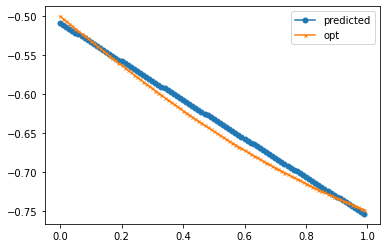

In [20]:
plt.plot(list(predicted_angles.keys()), list(predicted_angles.values()), label="predicted", marker="o", markersize=5)
plt.plot(list(opt_angles.keys()), list(opt_angles.values()), label="opt", marker="x", markersize=3)
plt.legend()
plt.show()

In [21]:
def meta_angle(x):
    a = tq.assign_variable("a")
    b = tq.assign_variable("b")
    c = tq.assign_variable("c")
    d = tq.assign_variable("d")
    return b*x**2 + c*x + d

In [22]:
meta_objective = 0.0
for x in training_points:
    meta_objective += tq.ExpectationValue(H=make_H(x), U=make_U(meta_angle(x)))

meta_objective = 1.0/len(training_points)*meta_objective
meta_vqe_result = tq.minimize(meta_objective, initial_values=0.0, silent=True)

predicted_angles = {}
opt_angles = {}
for x in test_points:
    predicted = meta_angle(x)(variables=meta_vqe_result.variables)
    predicted_angles[x] = predicted
    objective = tq.ExpectationValue(H=make_H(x), U=make_U("x"))
    opt = tq.minimize(objective, silent=True, initial_values=predicted)
    opt_angle = opt.variables["x"] 
    opt_angles[x] = opt_angle

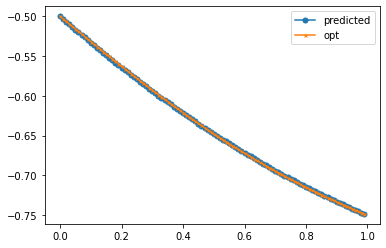

In [23]:
plt.figure()
plt.plot(list(predicted_angles.keys()), list(predicted_angles.values()), label="predicted", marker="o", markersize=5)
plt.plot(list(opt_angles.keys()), list(opt_angles.values()), label="opt", marker="x", markersize=3)
plt.legend()
plt.show()

## Example: Quantum Chemistry

<img src="pics/chemistry_overview.png" width="500px">

### Dependencies

- Basis set representation: Psi4  
    `conda install psi4 -c psi4`
- Basis-set-free: Madness  
  follow instructions on this fork: 
  [github.com/kottmanj/madness](https://github.com/kottmanj/madness)  
- Tutorials: [github.com/aspuru-guzik-group/tequila-tutorials](https://github.com/aspuru-guzik-group/tequila-tutorials)  

In [24]:
if "psi4" not in tq.chemistry.INSTALLED_QCHEMISTRY_BACKENDS.keys():
    raise Exception("Psi4 not found! Cells below won't evaluate, stopping notebook here.")

### Molecular Hamiltonian in Qubit Representation

In [25]:
geomstring = "H 0.0 0.0 0.0\nH 0.0 0.0 {R}".format(R=0.7)
mol = tq.Molecule(geometry=geomstring,basis_set="sto-3g")
H = mol.make_hamiltonian()

In [26]:
print(H)

-0.0421+0.1777Z(0)+0.1777Z(1)-0.2427Z(2)-0.2427Z(3)+0.1706Z(0)Z(1)+0.0448Y(0)X(1)X(2)Y(3)-0.0448Y(0)Y(1)X(2)X(3)-0.0448X(0)X(1)Y(2)Y(3)+0.0448X(0)Y(1)Y(2)X(3)+0.1229Z(0)Z(2)+0.1677Z(0)Z(3)+0.1677Z(1)Z(2)+0.1229Z(1)Z(3)+0.1763Z(2)Z(3)


### Hartree-Fock Reference State

In [27]:
U = mol.prepare_reference()
E = tq.ExpectationValue(H=H, U=U)
hf_energy = tq.simulate(E)
print("EHF = {:+2.5f}".format(hf_energy))

EHF = -1.11735


In [28]:
print(E)

Objective with 1 unique expectation values
total measurements = 15
variables          = []
types              = not compiled


In [29]:
E = tq.ExpectationValue(H=H, U=U, optimize_measurements=True)
print(tq.compile(E, backend="qiskit"))

Objective with 2 unique expectation values
total measurements = 2
variables          = []
types              = [<class 'tequila.simulators.simulator_qiskit.BackendExpectationValueQiskit'>]


In [54]:
geomstring = "H 0.0 0.0 0.0\nLi 0.0 0.0 {R}".format(R=0.7)
mol = tq.Molecule(geometry=geomstring, basis_set="sto-3g",
                  transformation="BravyiKitaev")
print(mol)

<class 'tequila.quantumchemistry.psi4_interface.QuantumChemistryPsi4'>
Qubit Encoding
transformation=<function bravyi_kitaev at 0x7f418cdffa70>

Parameters
basis_set       : sto-3g          
geometry        : H 0.0 0.0 0.0
Li 0.0 0.0 0.7 
description     :                 
multiplicity    : 1               
charge          : 0               
closed_shell    : True            
name            : molecule        

Psi4 Data
Point Group (full) : c_inf_v         
Point Group (used) : c2v             
nirrep          : 4 
irreps          : ['A1', 'A2', 'B1', 'B2'] 
mos per irrep   : [4, 0, 1, 1]    

Orbitals:
0 : 0A1 energy = -2.519793 
1 : 1A1 energy = -0.296569 
2 : 2A1 energy = +0.057778 
3 : 0B1 energy = +0.139822 
4 : 0B2 energy = +0.139822 
5 : 3A1 energy = +0.599617 



### Active Spaces

In [31]:
geomstring = "H 0.0 0.0 0.0\nLi 0.0 0.0 {R}".format(R=0.7)
active={"A1":[1,2]}
mol = tq.Molecule(geometry=geomstring,
                  basis_set="sto-3g",
                  active_orbitals=active)
H = mol.make_hamiltonian()

### Manually Construct an Ansatz

In [32]:
U = tq.gates.Ry(angle="a", target=0)
U += tq.gates.X(1)
U += tq.gates.X(target=1, control=0)
U += tq.gates.X(target=2, control=1)
U += tq.gates.X(target=3, control=2)
U += tq.gates.X(target=1)

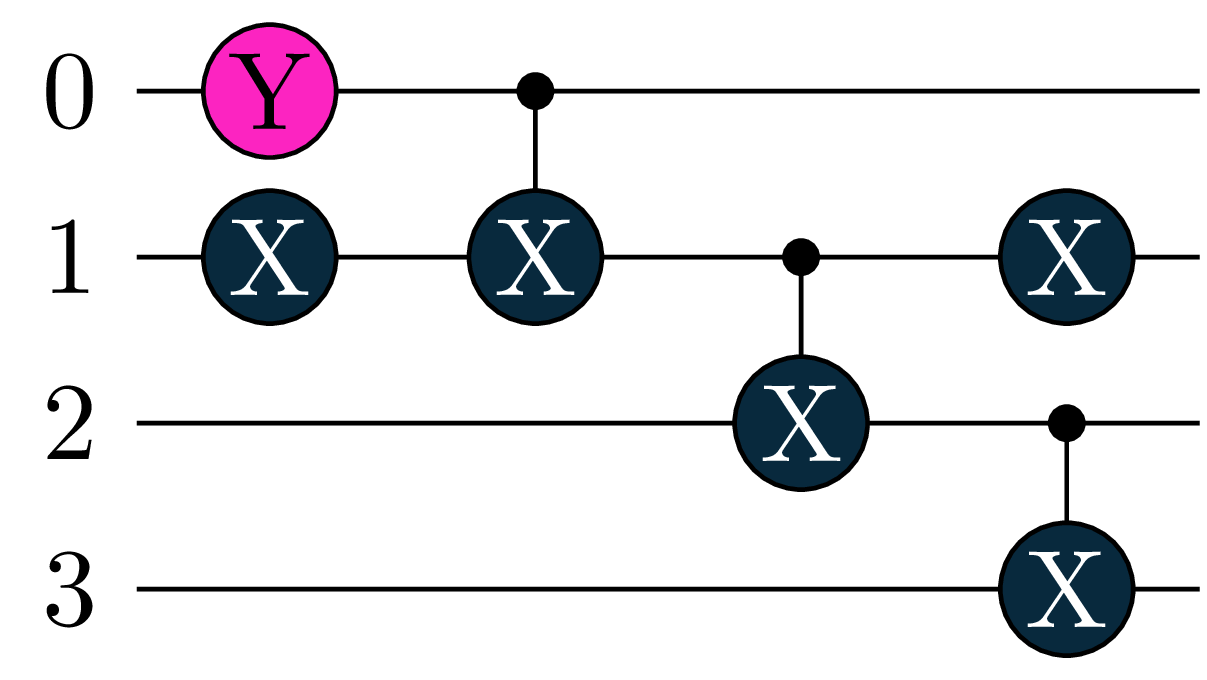

In [33]:
tq.draw(U)

### Optimize the Ansatz

In [34]:
E = tq.ExpectationValue(H=H, U=U)
result = tq.minimize(E)
energy_np = numpy.linalg.eigvalsh(H.to_matrix())[0]
energy_fci = mol.compute_energy("fci")

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 2 expectationvalues

active variables : 1

E=-6.95631152  angles= {a: 0.0}  samples= None
E=-6.95641192  angles= {a: -0.009415864944458008}  samples= None
E=-6.95704807  angles= {a: -0.04707932472229004}  samples= None
E=-6.96332136  angles= {a: -0.19773316383361816}  samples= None
E=-7.04345170  angles= {a: -0.8003485202789307}  samples= None
E=-7.48465953  angles= {a: -3.2108099460601807}  samples= None
E=-7.48119139  angles= {a: -2.913032986993547}  samples= None
E=-7.48611221  angles= {a: -3.106200173015701}  samples= None
Optimization terminated successfully.
         Current function value: -7.486112
         Iterations: 1
         Function evaluations: 8
         Gradient evaluations: 8


In [35]:
print("VQE   = {:2.5f}".format(result.energy))
print("FCI   = {:2.5f}".format(energy_fci))
print("Numpy = {:2.5f}".format(energy_np))

VQE   = -7.48611
FCI   = -7.48612
Numpy = -7.48612


### Manually construct an UCC ansatz

<img src="pics/ucc.png" width="700px">


In [36]:
G0213 = mol.make_excitation_generator(indices=[(0,2),(1,3)])
Uex = tq.gates.Trotterized(generator=G0213, angle="a")
U = mol.prepare_reference() + Uex

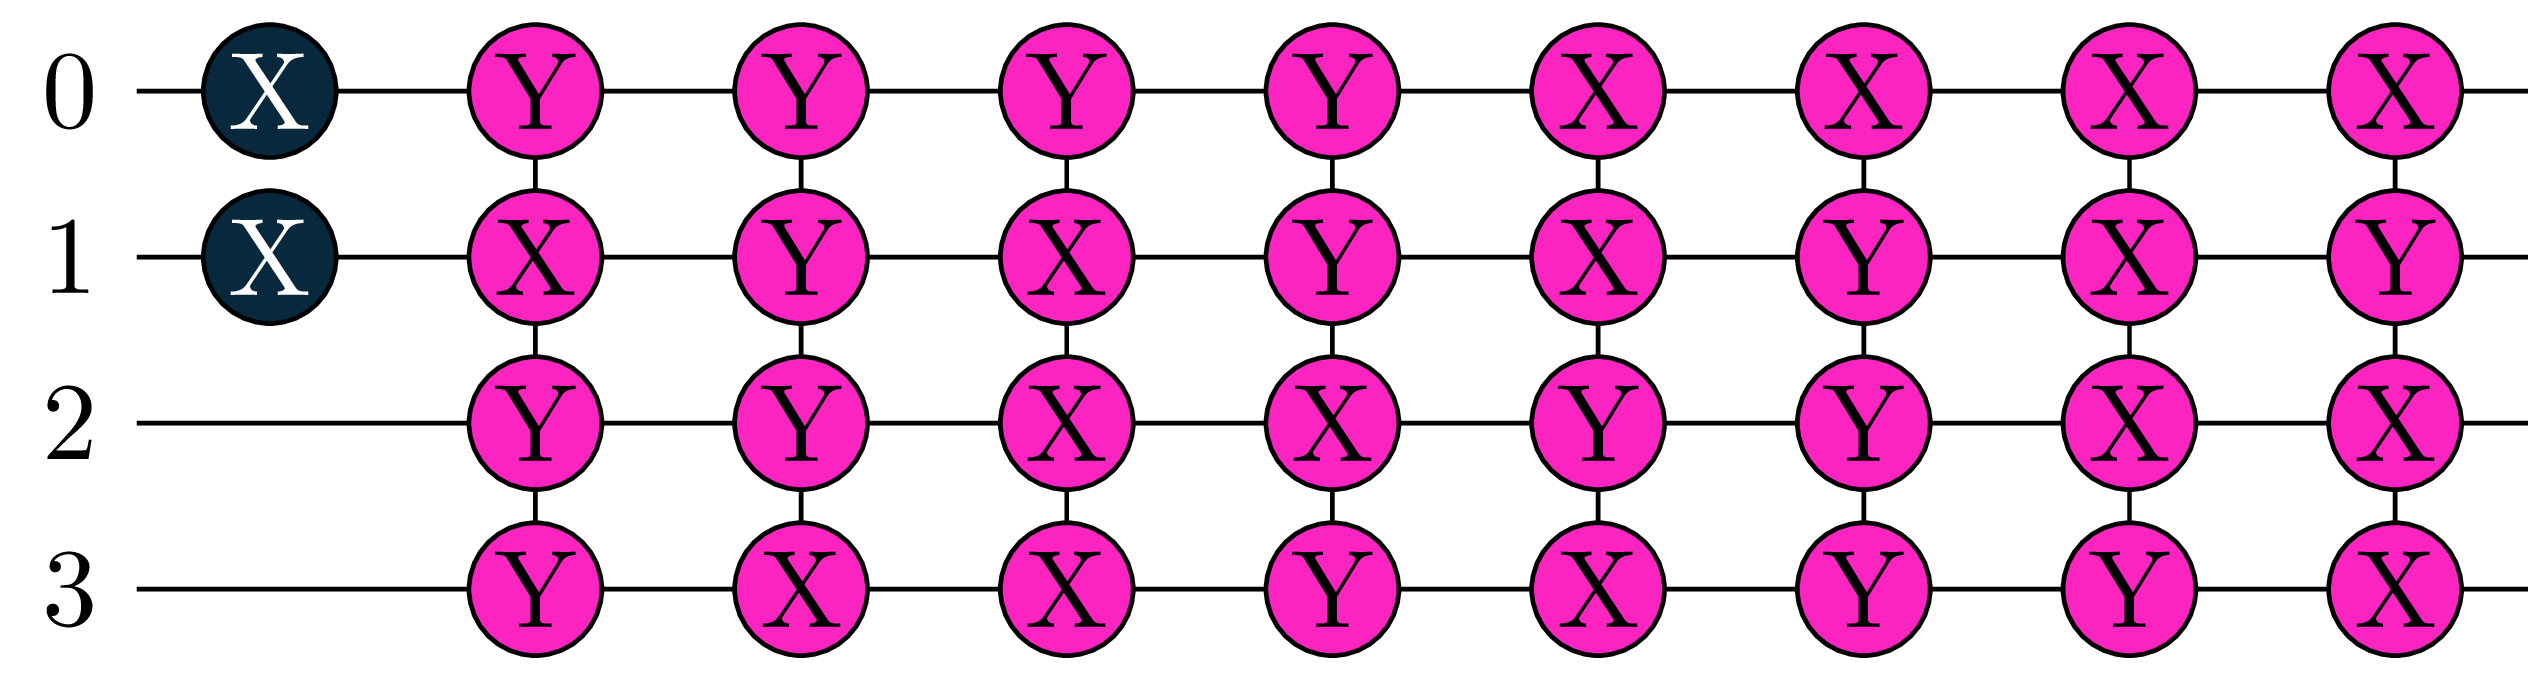

In [37]:
tq.draw(U)

In [38]:
E = tq.ExpectationValue(H=H, U=U)
result = tq.minimize(E)

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 16 expectationvalues

active variables : 1

E=-7.48594487  angles= {a: 0.0}  samples= None
E=-7.48602179  angles= {a: 0.009415864944458008}  samples= None
E=-7.48611042  angles= {a: 0.031862458915351874}  samples= None
Optimization terminated successfully.
         Current function value: -7.486110
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3


### Gradient Aware Construction

<img src="pics/gradient_fast_2.png" width="800px">

In [39]:
Uex = mol.make_excitation_gate([(0,2),(1,3)], "a")
U = mol.prepare_reference() + Uex
E = tq.ExpectationValue(H=H, U=U)

In [40]:
result = tq.minimize(E)

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 2 expectationvalues

active variables : 1

E=-7.48594487  angles= {a: 0.0}  samples= None
E=-7.48602179  angles= {a: 0.009415864944458008}  samples= None
E=-7.48611042  angles= {a: 0.031862458915351874}  samples= None
Optimization terminated successfully.
         Current function value: -7.486110
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3


In [6]:
madness_exe = tq.chemistry.QuantumChemistryMadness.find_executable(madness_root_dir="/home/jsk/devel/madness/build-opt/")
if madness_exe is None:
    raise Exception("Madness not found! Stopping notebook, cells below will not evaluate. Follow instructions in the readme here: https://github.com/kottmanj/madness")

### Quantum Chemistry: Constructing the Hamiltonian
<img src="pics/discretization.png" width="400px">

<img src="pics/basis-set-comic.png" width="500px">

- Well developed classical machinery
- Unknown numerical error
- Accurate results require large basis sets
- High level of expertise required from the user

<img src="pics/basis_sets_and_methods.png" width="1000px">

In [42]:
mol = tq.Molecule(geometry=geomstring, basis_set="cc-pVDZ")
print(mol.make_hamiltonian().n_qubits)

38


<img src="pics/mra-orbital-determination.png" width="500px">

- Basis-set-free
- Physically interpretable limitations
- Compact (save qubits)
- Natural order on orbitals
- Low level of expertise required from user

<img src="pics/basis_set_free_performance.png" width="1000px">

### More 

Basis-set-Free VQE:  
JSK, P. Schleich, T. Tamayo-Mendoza, A. Aspuru-Guzik [doi.org/10.1021/acs.jpclett.0c03410](https://doi.org/10.1021/acs.jpclett.0c03410) 

Surrogate Model (PNO-MP2):  
JSK, F. A. Bischoff, E. F. Valeev [doi.org/10.1063/1.5141880](https://doi.org/10.1063/1.5141880)  

Tequila backend: Madness  
R.J. Harrison *et.al.* [doi.org/10.1137/15M1026171](https://doi.org/10.1137/15M1026171)

MRA basics:  
[doi.org/10.18452/19357](https://doi.org/10.18452/19357) (Chapter 2)    
  
Review on classical applications:   
F.A. Bischoff, [doi.org/10.1016/bs.aiq.2019.04.003](https://doi.org/10.1016/bs.aiq.2019.04.003)

In [7]:
mol = tq.Molecule(geometry="Li 0.0 0.0 0.0\nH 0.0 0.0 1.6", 
                  n_pno=4,
                  executable=madness_exe,
                  name="lih_1.6")
H = mol.make_hamiltonian()
U = mol.make_pno_upccgsd_ansatz(include_singles=False)
E = tq.ExpectationValue(H=H, U=U)

In [8]:
print(mol)

<class 'tequila.quantumchemistry.madness_interface.QuantumChemistryMadness'>
Qubit Encoding
transformation=<function jordan_wigner at 0x7f90eb2efa70>

Parameters
basis_set       : custom          
geometry        : Li 0.0 0.0 0.0
H 0.0 0.0 1.6 
description     :                 
multiplicity    : 1               
charge          : 0               
closed_shell    : True            
name            : lih_1.6         

MRA Orbitals    :
orbital 0, occupied reference orbital (0,), energy -2.44107 
orbital 1, occupied reference orbital (1,), energy -0.305942 
orbital 2, pno from pair (1, 1), MP2 occ 0.0113194 
orbital 3, pno from pair (1, 1), MP2 occ 0.00479669 
orbital 4, pno from pair (1, 1), MP2 occ 0.00479458 
orbital 5, pno from pair (1, 1), MP2 occ 0.00419803 

executable      : /home/jsk/devel/madness/build-opt//src/apps/pno/pno_integrals
htensor         : lih_1.6_htensor.npy
gtensor         : lih_1.6_gtensor.npy



In [75]:
result = tq.minimize(E)

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 8 expectationvalues

active variables : 4

E=-7.98721057  angles= {(0, ((2, 4), (3, 5)), None): 0.0, (0, ((2, 6), (3, 7)), None): 0.0, (0, ((2, 8), (3, 9)), None): 0.0, (0, ((2, 10), (3, 11)), None): 0.0}  samples= None
E=-8.01593186  angles= {(0, ((2, 4), (3, 5)), None): 0.12768793106079102, (0, ((2, 6), (3, 7)), None): 0.09198546409606934, (0, ((2, 8), (3, 9)), None): 0.09202122688293457, (0, ((2, 10), (3, 11)), None): 0.09455657005310059}  samples= None
E=-8.02032262  angles= {(0, ((2, 4), (3, 5)), None): 0.21350067509853055, (0, ((2, 6), (3, 7)), None): 0.14165840203560198, (0, ((2, 8), (3, 9)), None): 0.14177428603515832, (0, ((2, 10), (3, 11)), None): 0.13429117589170406}  samples= None
E=-8.02036286  angles= {(0, (

### Example: Adaptive Solvers

<img src="pics/adaptive_algorithms_cartoon.png" width="400px">

Original approaches:  
Ryabynkin, Yen, Genin, Izmaylov, [doi.org/10.1021/acs.jctc.8b00932](https://doi.org/10.1021/acs.jctc.8b00932)  
Grimsley, Economou, Barnes, Mayhall [doi.org/10.1038/s41467-019-10988-2](https://doi.org/10.1038/s41467-019-10988-2)  

### Example: Adaptive Solvers

<img src="pics/adaptive_general_wbg.png" width="400px">

Tequila implementation:  
JSK, Anand, Aspuru-Guzik. [doi.org/10.1039/D0SC06627C](https://doi.org/10.1039/D0SC06627C)

More examples on [github](https://github.com/aspuru-guzik-group/tequila-tutorials/blob/main/AdaptiveSolver.ipynb)

In [9]:
operator_pool = tq.apps.adapt.MolecularPool(molecule=mol, 
                                            indices="UpCCGSD")
solver = tq.apps.adapt.Adapt(operator_pool=operator_pool, 
                             H=mol.make_hamiltonian(), 
                             Upre=mol.prepare_reference())
result = solver()

Starting Adaptive Solver
optimizer_args                 : {'method': 'bfgs'}
compile_args                   : {}
maxiter                        : 100
energy_convergence             : None
gradient_convergence           : 0.01
max_gradient_convergence       : 0.0
degeneracy_threshold           : 0.0001
operator pool:                 : MolecularPool with 45 Generators
objective factory :            : ObjectiveFactoryBase

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 2 expectationvalues

active variables : 1

E=-7.98721057  angles= {(((2, 4), (3, 5)), (0, 0)): 0.0}  samples= None
E=-7.99916644  angles= {(((2, 4), (3, 5)), (0, 0)): 0.12768793106079102}  samples= None
E=-8.00241089  angles= {(((2, 4), (3, 5)), (0, 0)): 0.23849312692390365}  samples= None
Optimization ter

E=-8.02048573  angles= {(((2, 4), (3, 5)), (0, 0)): 0.22283865865781968, (((2, 10), (3, 11)), (1, 0)): 0.1259990399483573, (((2, 8), (3, 9)), (2, 0)): 0.1387374575540267, (((2, 6), (3, 7)), (3, 0)): 0.13921443619448012, (((0, 10), (1, 11)), (4, 0)): 0.004438309189553299, (((2, 4),), (5, 0)): -0.014225118429425795, (((3, 5),), (5, 0)): -0.014225118429425795}  samples= None
Optimization terminated successfully.
         Current function value: -8.020486
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
-------------------------------------
Finished iteration 5
current energy : -8.02048573
difference     : +0.00008205
grad_norm      : +0.01079170
max_grad       : +0.00575519
circuit size   : 7
pool gradient norm is +0.00711192, convergence criterion met


### Example: Molecular Meta-VQE


In [47]:
def meta_angle(R):
    a = tq.assign_variable("a")
    b = tq.assign_variable("b")
    c = tq.assign_variable("c")
    d = tq.assign_variable("d")
    return a*(-(b*R-c)**2).apply(tq.numpy.exp) + d
    
def make_U(mol, angle):
    U = mol.prepare_reference()
    U += mol.make_excitation_gate([(0,2),(1,3)], angle)
    return U

In [48]:
geomstring = "H 0.0 0.0 0.0\nH 0.0 0.0 {R}"
training_points = [0.5, 1.0, 1.5, 3.0]
meta_objective = 0.0
for R in training_points:
    mol = tq.Molecule(name="H2_R_{R:1.4f}".format(R=R), geometry=geomstring.format(R=R), n_pno=1, executable=madness_exe)
    H = mol.make_hamiltonian()
    U = make_U(mol, meta_angle(R))
    E = tq.ExpectationValue(H=H, U=U)
    meta_objective += E

meta_objective = 1.0/len(training_points)*meta_objective
meta_vqe_result = tq.minimize(meta_objective, initial_values={"b":1.0, "c":1.0})

Starting madness calculation with executable:  /home/jsk/devel/madness/build-opt//src/apps/pno/pno_integrals
output redirected to H2_R_0.5000_pno_integrals.out logfile
finished after 15.370546817779541s
Starting madness calculation with executable:  /home/jsk/devel/madness/build-opt//src/apps/pno/pno_integrals
output redirected to H2_R_1.0000_pno_integrals.out logfile
finished after 14.80038332939148s
Starting madness calculation with executable:  /home/jsk/devel/madness/build-opt//src/apps/pno/pno_integrals
output redirected to H2_R_1.5000_pno_integrals.out logfile
finished after 15.434062242507935s
Starting madness calculation with executable:  /home/jsk/devel/madness/build-opt//src/apps/pno/pno_integrals
output redirected to H2_R_3.0000_pno_integrals.out logfile
finished after 17.48304271697998s


 /home/jsk/projects/OpenVQE/src/tequila/optimizers/optimizer_base.py:422: TequilaWarning:initial_variables given but not complete: Autocompleted with zeroes


Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 4 expectationvalues
gradient        : 48 expectationvalues

active variables : 4

E=-1.34122288  angles= {a: 0.0, b: 1.0, c: 1.0, d: 0.0}  samples= None
E=-1.36554265  angles= {a: 0.11155933141708374, b: 1.0, c: 1.0, d: 0.17781761288642883}  samples= None
E=-1.36658454  angles= {a: 0.10272243630136521, b: 0.9935534159295202, c: 1.0064019139845308, d: 0.21499432013083114}  samples= None
E=-1.36833477  angles= {a: 0.058099494256050405, b: 0.9775900773692061, c: 1.023056394046223, d: 0.28127795022067165}  samples= None
E=-1.37103558  angles= {a: -0.05316870764747138, b: 0.9473497192317459, c: 1.0546766680502973, d: 0.3993030301002968}  samples= None
E=-1.37367809  angles= {a: -0.23638881867206418, b: 0.9141771490413152, c: 1.087514230006737, d: 0.549572043032526

In [49]:
steps=10
start=0.25
stop=5.0
test_points=[start + x/steps*(stop-start) for x in range(steps)]
predicted_angles = {}
predicted_energies = {}
opt_angles = {}
opt_energies = {}
for R in test_points:
    predicted = meta_angle(R)(variables=meta_vqe_result.variables)
    predicted_angles[R] = predicted
    mol = tq.Molecule(name="H2_R_{R:1.4f}".format(R=R), geometry=geomstring.format(R=R), n_pno=1, executable=madness_exe)
    H = mol.make_hamiltonian()
    U = make_U(mol, angle="x")
    objective = tq.ExpectationValue(H=H, U=U)
    predicted_energies[R] = tq.simulate(objective, variables={"x":predicted})
    opt = tq.minimize(objective, silent=True, initial_values={"x":predicted})
    opt_angles[R] = opt.variables["x"] 
    opt_energies[R] = opt.energy
    print("R = {}, energy = {:2.5f}".format(R, opt.energy), " wfn=", tq.simulate(U, variables=opt.variables))

Starting madness calculation with executable:  /home/jsk/devel/madness/build-opt//src/apps/pno/pno_integrals
output redirected to H2_R_0.2500_pno_integrals.out logfile
finished after 16.07549262046814s
R = 0.25, energy = -0.40852  wfn= +0.9982|1100> -0.0606|0011> 
Starting madness calculation with executable:  /home/jsk/devel/madness/build-opt//src/apps/pno/pno_integrals
output redirected to H2_R_0.7250_pno_integrals.out logfile
finished after 14.785600185394287s
R = 0.7250000000000001, energy = -1.52834  wfn= +0.9949|1100> -0.1007|0011> 
Starting madness calculation with executable:  /home/jsk/devel/madness/build-opt//src/apps/pno/pno_integrals
output redirected to H2_R_1.2000_pno_integrals.out logfile
finished after 15.511678218841553s
R = 1.2000000000000002, energy = -1.18528  wfn= +0.9808|1100> -0.1950|0011> 
Starting madness calculation with executable:  /home/jsk/devel/madness/build-opt//src/apps/pno/pno_integrals
output redirected to H2_R_1.6750_pno_integrals.out logfile
finishe

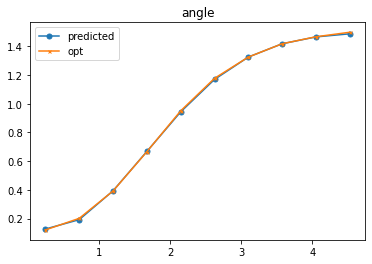

In [50]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(list(predicted_angles.keys()), list(predicted_angles.values()), label="predicted", marker="o", markersize=5)
plt.plot(list(opt_angles.keys()), list(opt_angles.values()), label="opt", marker="x", markersize=3)
plt.title("angle")
plt.legend()

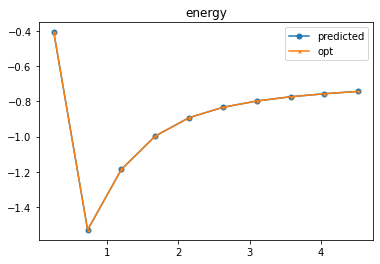

In [51]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(list(predicted_energies.keys()), list(predicted_energies.values()), label="predicted", marker="o", markersize=5)
plt.plot(list(opt_energies.keys()), list(opt_energies.values()), label="opt", marker="x", markersize=3)
plt.title("energy")
plt.legend()

### Suggestions

<img src="pics/tq_to_pl.png" width="1400px">


<img src="pics/ack.png" width="1400px">


- Overview: [Arxiv:2011.03057](https://arxiv.org/abs/2011.03057)  
- Code & Tutorials: [github.com/aspuru-guzik-group/tequila](https://github.com/aspuru-guzik-group/tequila)  
- Install: `pip install git+https://github.com/aspuru-guzik-group/tequila.git`  
- Not to be confused with the Minecraft server manager :-)
~~`pip install tequila`~~